# ATOC5860 Application Lab 6 - Self-Organizing Maps

##### Written by Dr. Gina Jozef (ATOC Ph.D.), with small updates from Prof. Jennifer Kay (ATOC CU)
##### last updated April 15, 2024

### LEARNING GOALS:
1. Apply self organizing maps as an example of unsupervised (grouping events into different categories) machine learning. Build understanding of the technique for Bay of Bengal circulation (sea level pressure anomaly) and precipitation.
2. Assess the influence of user specified parameters on the SOM results.  Use Sammon maps and other statistical tests to assess the fit of the SOM the training data.  Compare a 3x3 node SOM vs. a 4x4 node SOM. You should find that the Sammon map looks better for the 3x3 SOM than for the 4x4 SOM.  The 4x4 sammon map has twisting indicating you may not need so many patterns to describe the data.  Too much twisting = too many nodes.
3. Map a composite variable (in this case precipitation) to the self organizing map nodes (in this case based on sea level pressure anomaly).  Understand the added value of associating additional variables to a SOM.
 

### DATA and UNDERLYING SCIENCE MOTIVATION:

Here, we use self-organizing maps (S0M) to assess patterns of sea level pressure variability and precipitation in the Bay of Bengal. We will be working daily (at 12 UTC) ERA5 reanalysis data from 2020 to 2022.  The dataset is small so that you can tinker without waiting too long.... This entire notebook should run on a personal computer in < 10 minutes.

To begin, we train the SOM using the daily spatial maps of sea level pressure (SLP) anomaly (the anomaly at each grid point with respect to the domain averaged of SLP). The SOM is trained with SLP anomaly rather than SLP magnitude because SLP gradients, rather than absolute values of SLP, are responsible for dictating near-surface circulation. The result of the SOM training are SOM patterns which depict the range in SLP anomaly patterns present in the training data. The number of SOM patterns is user-specified. 

Next, each data point in the training data set will be "mapped" to the SOM pattern to which it is most similar, i.e., its best matching unit (BMU).  Similarity is established quantitatively using the least squared difference.

Next, we determine and visualize the relative frequencies of each SOM pattern. 

Finally, we analyze and visualize how a 'composite variable' maps to the individual SOM pattern. In this case, total precipitation is the composite variable that we map to the sea level pressure SOM. In a SOM analysis, additional value often comes from linking composite variables to the SOM patterns. 

**Question to guide your analysis** 

When training a SOM, there are various parameters which are specified by the user.  It is advised to test out multiple combinations of parameters to find the combination which "best" trains the SOM. In order to determine if one SOM is better-trained than another, you will create sammon maps, and calculate various statistical values which reveal how well the SOM fits the training data. 


In [1]:
### NOTE: To complete this lab, you will need to add packages NOT installed by default in the atoc5860 environment
### you will need to install them at the command line before you run this code.

### FIRST -- You may want to make a new environment, just in case this breaks something.
## conda create -n new_environment --clone your_current_environment
## e.g. for me, conda create -n culabenv2024_ml --clone culabenv2024

### SECOND - activate the new environment and install the relevant package using pip install
## type "conda activate culabenv2024_ml"
## Install the SOM package by typing "pip install GEMA" at the command line.
## If you want to download ERA5 data yourself (optional), Install the necessary package by typing  "pip install cdsapi"

### ALSO -- you'll need the script sammon.py to be stored in the same folder as this notebook for the code to run!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib import colors
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pickle
from scipy.stats import pearsonr
import GEMA # Information about this package can be found at: https://github.com/ufvceiec/GEMA

## Download data

This step may be skipped if you have the file ERA5_SLP_TP.nc.

If you would like the download the data. More information can be found here: https://cds.climate.copernicus.eu/api-how-to.  You will need to create an account, make a text file called "~/.cdsapirc" that has two lines containing the url and key of your account, and also sign the "Licence to use Copernicus Products".

In [3]:
download="no"

if download=="yes":
    import cdsapi #Informaton about this package can be found at: https://pypi.org/project/cdsapi/ 
    
    import logging
    logging.captureWarnings(True)
    
    ## Download Sea Level Pressure and Total Precipitation data from ERA5.

    c = cdsapi.Client()

    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'format': 'netcdf',
            'variable': [
                'mean_sea_level_pressure', 'total_precipitation',
            ],
            'year': [
                '2020', '2021', '2022',
            ],
            'month': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'day': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
                '13', '14', '15',
                '16', '17', '18',
                '19', '20', '21',
                '22', '23', '24',
                '25', '26', '27',
                '28', '29', '30',
                '31',
            ],
            'time': '12:00',
            'area': [
                25, 78, 5,
                98,
            ],
        },
        'ERA5_SLP_TP.nc')    

### OK - Let's make some SOM!

## Step 1: Read in the SLP data

In [4]:
## Define dataset location ##
file = 'ERA5_SLP_TP.nc'

## Open dataset ##
ds = xr.open_dataset(file)

## Read in the variables ##
lats = ds.latitude # Latitude, from 78 to 98 degrees N, with 0.25 degree resolution
lons = ds.longitude # Longitude, from 5 to 25 degrees N, with 0.25 degree resolution
slp = ds.msl # Sea level pressure, in Pa
times = ds.time # Time, in hours since 1900-1-1 0:0:0, from 2020 to 2022

## Save new variables which contain only the data for each variable ##
lats_data = lats.data
lons_data = lons.data
slp_data = slp.data/100 #convert from Pa to hPa
times_data = times.data

## Print the shape of each variable to check for consistency ##
# The shape of 'slp_data' should be shapes of (Time, Latitude, Longitude)
print('Time: ' + str(np.shape(times_data)))
print('Latitude: ' + str(np.shape(lats_data)))
print('Longitude: ' + str(np.shape(lons_data)))
print('SLP: ' + str(np.shape(slp_data)))
## Check that the dimensions of the SLP variable are correct
if (np.shape(slp_data)[0] == len(times_data)) == True & (np.shape(slp_data)[1] == len(lats_data)) == True & (np.shape(slp_data)[2] == len(lons_data)) == True:
    print('Success!')
else:
    print('Something is wrong...')
    

Time: (1096,)
Latitude: (81,)
Longitude: (81,)
SLP: (1096, 81, 81)
Success!


## Step 2: Prepare the SLP data to be read by the SOM algorithm

The SOM algorithm is expecting data in the format of a 2D variable such that y = case # and x = data. Since the SLP data is originally provided as a 3D variable, where z = time, y = latitude, x = longitude, masked by the SLP value at that lat/lon/time, we must flatten the SLP data from each case. This means we take the 2D SLP data from a given case and arrange it in a 1D array with length len(latitude) x len(longitude). After this is performed for each case, and combined into a single array containing all of the training data, we end up with a 2D variable where y = case # and x = data. This will be performed by the below cell. 

Additionally, as we flatten the SLP data for each case, we convert SLP magnitude (at each grid point) to SLP anomaly (at each grid point) by calculating the difference from the domain averaged SLP (for that case).

In [5]:
## Determine lens
len_time = len(times_data)
print('Length of time variable: ' + str(len_time))
len_lat = len(lats_data)
print('Length of latitude variable: ' + str(len_lat))
len_lon = len(lons_data)
print('Length of longitude variable: ' + str(len_lon))

## Initialize some variables
a,b = np.shape(slp_data[0,:,:])
idx_flat = a*b
slp_anom_flat = np.empty(shape=(len_time, idx_flat), dtype='object')

## Loop through all times and for each time: subtract the domain average from each SLP value and flatten.
## Then combine all information into a single variable which contains the flattened anomaly data for all times.
for i in list(range(len_time)):

    # Select the SLP data for one time
    slp_now = slp_data[i,:,:]
    
    # Derermine the domain average of SLP
    mean_slp_now = np.mean(slp_now[:,:]) 
    
    # Subtract the domain average from the SLP data for the current case
    slp_now_anom_temp = slp_now-mean_slp_now
    
    # Flatten the data
    slp_now_anom = slp_now_anom_temp.reshape(a*b) 
    
    # Save SLP data to variable which stores the flattened data for all times
    slp_anom_flat[i,:] = slp_now_anom
    
## Print the shape of the flattened SLP variable, to check that it is correct.
print('Shape of flattened SLP variable: ' + str(np.shape(slp_anom_flat)))
if (np.shape(slp_anom_flat)[0] == len(times_data)) == True & (np.shape(slp_anom_flat)[1] == len(lats_data)*len(lons_data)) == True:
    print('Success!')
else:
    print('Something is wrong...')
    

Length of time variable: 1096
Length of latitude variable: 81
Length of longitude variable: 81
Shape of flattened SLP variable: (1096, 6561)
Success!


## Step 3: Train the SOM

In the following step, you will train the SOM using the training variable 'slp_anom_flat.' There are several user-specified training variables which you can change in this activity. These are:

- **map size** (indicated by variable 'i'): This will determine the size of the SOM. For example, a map size of 3 will create a 3x3 SOM. The code is set up below to train both a 3x3 and 4x4 SOM with the same period and learning rate (see next bullet points). Thus, after running the below cell, you will have two SOM output files that you can run through the future cells to compare the outputs. If you have time, you can try some other options to compare the output. Recommended options to try: 2, 3, 4, 5, 6
- **period** (indicated by variable 'j'): This will set the training period, which is the number of times that all cases in the training dataset are introduced to the SOM algorithm, thus working to adjust the SOM patterns to better match the data. The period can be any number, but generally, the higher the number, the better trained the SOM will be (too a point, past which the SOM output may be subject to over-fitting). The code is set up below to train with a period of 10000. If you have time, you can try some other options to compare the output. Recommended options to try: 1000, 5000, 50000, 100000 (a choice of 1000 or 5000 will lead to a relatively poorly-trained SOM, but it will take less time to run, so can be used as a check to make sure things are working properly)
- **learning rate** (indicated by variable 'k'): This will set the learning rate, which dictates how much a training data case is allowed to change the SOM patterns which introduced to the SOM during training. Learning rate must be a value between 0 and 1, where a higher number means the SOM patterns will be more heavily impacted by each training data case. If you use too low of a learning rate, the SOM patterns may not match the data very well, but if you use too high of a learning rate, the SOM output may be subject to over-fitting. The code is set up below to train with a learning rate of 0.3. If you have time, you can try some other options to compare the output. Recommended options to try: 0.1, 0.2, 0.4, 0.5


Note that the neighborhood size is specified as the map size minus 1.  You could also tinker with this paramete (initial_neightborhood).

Here, we have done a subjective sweep of the parameter space - We'll evaluate our parameter selection later.

In [6]:
%%time

## Define the training variable
training_data = slp_anom_flat

## Loop through various training parameters. Each set of parameters will train a different SOM
for i in [3,4]: 
    for j in [10000]: 
        for k in [0.3]:
           
            # Specify user-defined parameters, based on the values given in the above for-loops
            map_size = i 
            period = j
            learning_rate = k

            # Train the SOM
            main_map = GEMA.Map(training_data, 
                                map_size, 
                                period, 
                                initial_lr=learning_rate, 
                                initial_neighbourhood = map_size-1,
                                distance = 'euclidean',
                                use_decay= True,
                                normalization = 'non',
                                presentation = 'sequential',
                                weights = 'sample')

            # Determine the SOM pattern to which each individual case in the training data set maps
            main_classification = GEMA.Classification(main_map, training_data)

            # Save the SOM output to a pickle file that can later be loaded for further analysis
            save_name = "n"+str(map_size)+"_p"+str(period)+"_lr"+str(learning_rate)

            with open('SOM_Output_'+save_name+'.pickle', 'wb') as f:
                pickle.dump([main_classification, main_map], f)
                

TRAINING...


  0%|          | 0/10000 [00:00<?, ?it/s]

FINISHED.


  0%|          | 0/1096 [00:00<?, ?it/s]

TRAINING...


  0%|          | 0/10000 [00:00<?, ?it/s]

FINISHED.


  0%|          | 0/1096 [00:00<?, ?it/s]

CPU times: user 6min 4s, sys: 5.67 s, total: 6min 10s
Wall time: 6min 9s


## IMPORTANT FOR REST OF NOTEBOOK: Choose the SOM output file you would like to analyze

**Since the previous step may have produced multiple SOM output files, you will now need to choose one SOM output file on which to perform the analysis provided in the rest of this notebook.**

In [7]:
## Load in the SOM output file that you'd like to analyze and plot from here on out.
map_size = 3
period = 10000
learning_rate = 0.3

load_name = "n"+str(map_size)+"_p"+str(period)+"_lr"+str(learning_rate)

with open('SOM_Output_'+load_name+'.pickle', 'rb') as f:
    main_classification, main_map = pickle.load(f)

## Step 4: Save SOM patterns and BMUs in 2D and 1D variables

The GEMA package stores the SOM output in a 3D variable based on the shape of the grid, as determined by the map_size variable. For future analysis, it is easier if the SOM pattern data are stored in a 2D array such that y = SOM pattern # and x = SOM pattern data (this is still a flattened version of the data).

The GEMA package stores the BMU values (to which SOM pattern each case is mapped) in a 2D variable based on the shape of the grid, as determined by the map_size variable. For future analysis, it is easier if the BMU values are stored in a 1D array with y = case # and x = BMU for that case.

The below cell perfoms these conversions.

In [8]:
## Save SOM patterns into 2D variable with dimensions: [number of SOM patterns] x [len(lats_data) x len(lons_data)]
som = np.empty(shape=(map_size**2, idx_flat), dtype='object')
for i in list(range(0,map_size)):
    for j in list(range(0,map_size)):
        som[i+map_size*j,:]= main_map.weights[i,j,:]
        
## Save list of BMUs (what SOM pattern each case maps to) into 1D variable with dimensions: [total number of cases] x [1]
som_nums = np.empty(shape=(map_size,map_size), dtype='object')  
for i in list(range(0,map_size)):
    temp = np.array(list(range(0,map_size**2)))
    som_nums[i,:] = temp[map_size*i:map_size*(i+1)]
    
bmus = np.empty(shape=(len(times_data),1), dtype='object')
for i in list(range(0,len(times_data))):
    y_idx = main_classification.classification_map.y[i]
    x_idx = main_classification.classification_map.x[i]

    bmus[i] = som_nums[y_idx,x_idx]

## Step 5: Visualize the SOM output

Now we will create a figure with a number of subplots based on the map size which show the SOM patterns as spatial maps of SLP anomaly. During this step, the SOM pattern data will be unflattened (converted back to a lat/lon grid) for purposes of plotting. 

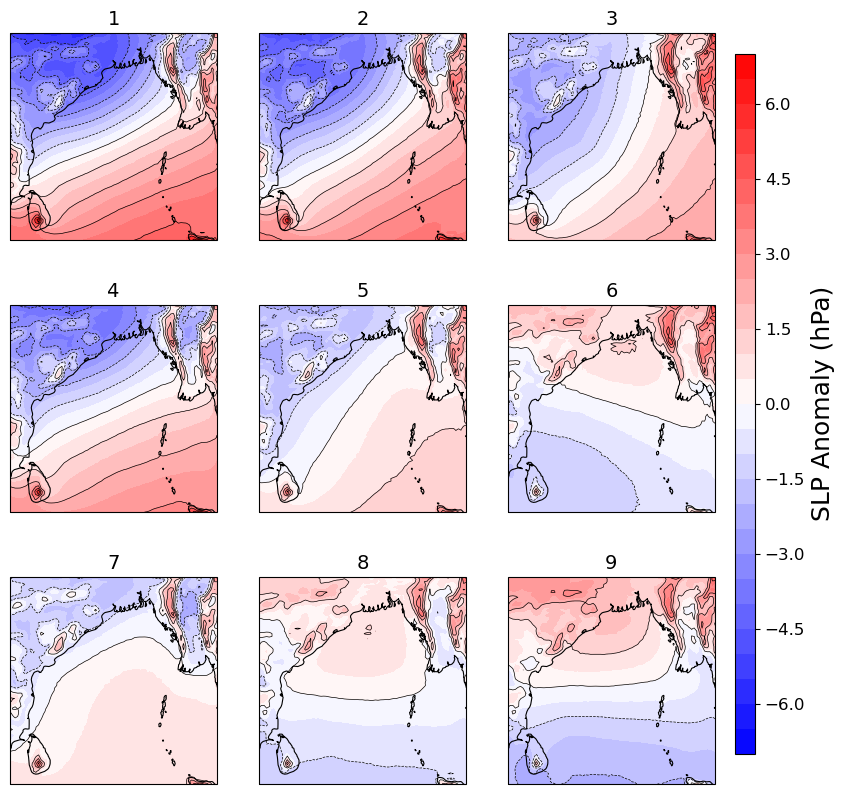

In [9]:
##  Visualize SOM Patterns

# Define some variables
cc = np.array(list(range(0,map_size**2)))+1    
slp_levels = np.arange(-7,7.05,0.5) 
slp_levels2 = np.arange(-7,7,1) 
datacrs = ccrs.PlateCarree()

# Make Figure
fig, axs = plt.subplots(nrows=map_size, ncols=map_size, figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})    
axs = axs.ravel()
for i in list(range(0,map_size**2)):
    # Unflatten the SOM pattern data for plotting
    som_img = som[i,:].reshape(a,b)  
    # Set up the map 
    axs[i].set_extent([78, 98, 5, 25], datacrs)
    axs[i].add_feature(cfeature.LAND, facecolor="#bdbdbd") 
    axs[i].coastlines('50m', linewidth=0.8) 
    axs[i].set_title(cc[i],fontsize=14)
    # Define x, y, and z variables for plotting
    x,y = np.meshgrid(lons_data,lats_data)   
    z = som_img.astype(float)  
    # Plot the SOM pattern
    ci = axs[i].contourf(x,y,z, levels=slp_levels, cmap=get_cmap('bwr'), alpha=1, transform=ccrs.PlateCarree())
    ci2 = axs[i].contour(x,y,z, levels=slp_levels2, colors="black", linewidths=0.5, transform=ccrs.PlateCarree())
fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cb = fig.colorbar(ci, cax=cbar_ax)
cb.ax.tick_params(labelsize=12)
cb.set_label('SLP Anomaly (hPa)',fontsize=18)
# Save figure
plt.savefig('SOM_Patterns_'+load_name+'.jpg')


## Step 6: Create sammon map

A sammon map is a depiction of how each each SOM pattern differs from the others. If a SOM is well-trained, the sammon map should look like a relatively uniform grid, with no overlapping lines, twisting, or curling. A uniform grid indicates that the magnitudes of the differences between each adjacent SOM pattern are relatively equal, and that the most similar patterns are located next to each other while the most different SOM patterns are located in opposite corners. 

epoch = 1 : E = 0.0001310031
epoch = 2 : E = 0.0000824143
epoch = 3 : E = 0.0000153766
epoch = 4 : E = 0.0000137703
epoch = 5 : E = 0.0000104854
epoch = 6 : E = 0.0000095229
epoch = 7 : E = 0.0000089274
epoch = 8 : E = 0.0000085540
epoch = 9 : E = 0.0000083403
epoch = 10 : E = 0.0000082494
epoch = 11 : E = 0.0000078291
epoch = 12 : E = 0.0000077060
epoch = 13 : E = 0.0000076202
epoch = 14 : E = 0.0000075621
epoch = 15 : E = 0.0000075256
epoch = 16 : E = 0.0000075068
epoch = 17 : E = 0.0000075054
epoch = 18 : E = 0.0000074333
epoch = 19 : E = 0.0000074193
epoch = 20 : E = 0.0000074096
epoch = 21 : E = 0.0000074032
epoch = 22 : E = 0.0000073995
epoch = 23 : E = 0.0000073981
epoch = 24 : E = 0.0000073897
epoch = 25 : E = 0.0000073875
epoch = 26 : E = 0.0000073859
epoch = 27 : E = 0.0000073848
epoch = 28 : E = 0.0000073841
epoch = 29 : E = 0.0000073838
epoch = 30 : E = 0.0000073837
epoch = 31 : E = 0.0000073824
epoch = 32 : E = 0.0000073821
epoch = 33 : E = 0.0000073820
epoch = 34 : E = 0.

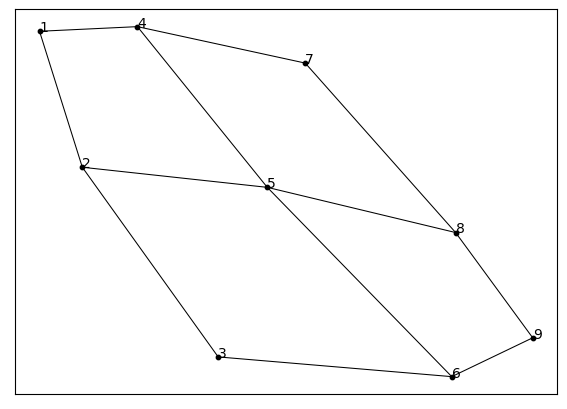

In [10]:
## Run sammon.py script in the background to load the function
with open("sammon.py") as f:
    exec(f.read())
    
## Run the SOM pattern data through the sammon.py script
som_data = (som.astype(float))
sammon_labels = list(range(1,map_size**2+1))  
y = sammon(som_data,2)

## Plot the sammon map
plt.figure(figsize=(7,5))
plt.scatter(y[0][:,0], y[0][:,1], s=10, c='k', marker='o')
for i in list(range(map_size**2)):
    plt.text(y[0][i,0], y[0][i,1],str(sammon_labels[i]),fontsize=10)
for i in list(np.arange(0, map_size**2, map_size)):
    for j in list(range(map_size-1)):
        plt.plot([y[0][i+j,0], y[0][i+j+1,0]],[y[0][i+j,1], y[0][i+j+1,1]],c='k',linewidth=0.75)
    for j in list(range(map_size)):    
        if i+j+map_size < map_size**2:
            plt.plot([y[0][i+j,0], y[0][i+j+map_size,0]],[y[0][i+j,1], y[0][i+j+map_size,1]],c='k',linewidth=0.75)
ax = plt.gca()
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([])
# Save figure
plt.savefig('Sammon_Map_'+load_name+'.jpg') 

No overlap for 3x3. Twists in 4x4 perhaps an overfit. 2x2 is difficult to twist and likely does not have enough information. No twists for 6x6, surprisingly. The 6x6 looks stunningly and surprisingly neat. Likely due to some extra complexity compared to a 3x3 that 4x4 and 5x5 did not pick up. 

## Step 7: Determine how well the SOM fits the data

In addition to looking at a sammon map, various statistical values can be calculated to reveal how well the SOM patterns represents the actual data. Some common metrics include root mean squared difference (RMSD), bias, and correlation coefficient. For a SOM analysis, each of these statistical values is calculated for each individual case, by comparing the case and the SOM pattern to which the case is mapped, and then taking an average across all cases. 

The most useful metric is often the RMSD, as it is not impacted by the sign of the difference, and is thus better retained when taking an average across all cases. Also, RMSD is given in the same units as those of the training data and SOM patterns, so its meaning is easily understood. Bias is usually less useful because when taking an average across all cases, instances of the same magnitude of bias but with opposite signs will cancel each other out.

The statistical values will almost always have values that show a better match to the data (lower RMSD and bias, and higher correlation coefficient) when the map size is increased. This doesn't necessarily mean that the bigger map size is the better choice. It all depends on what the goal of your study is. These statistics are better used not to choose between map sizes, but rather to choose which training period and training length within a set map size produces better results.

In [11]:
## Create a grid that contains the SOM pattern number
som_nums = np.empty(shape=(map_size,map_size), dtype='float')  
for i in list(range(0,map_size)):
    temp = np.array(list(range(0,map_size**2)))
    som_nums[i,:] = temp[map_size*i:map_size*(i+1)]
    
# Root Mean Squared Difference - a lower value means the data match the SOM better
RMSD_each = np.empty(shape=(len(slp_anom_flat[:,0])), dtype='float')   
for i in list(range(len(slp_anom_flat[:,0]))):
    RMSD_each[i] = np.sqrt((np.sum((som[bmus[i][0],:] - slp_anom_flat[i,:])**2))/len(slp_anom_flat[0,:]))

RMSD = round(np.nanmean(RMSD_each),2)
print('RMSD = ' + str(RMSD) + ' hPa')

## Bias - a lower value means the data match the SOM better
bias_each = np.empty(shape=(len(slp_anom_flat[:,0])), dtype='float')   
for i in list(range(len(slp_anom_flat[:,0]))):
    bias_each[i] = (np.sum((som[bmus[i][0],:] - slp_anom_flat[i,:])))/len(slp_anom_flat[0,:])

bias = round(np.nanmean(bias_each),2)
print('Bias = ' + str(bias) + ' hPa')

## Correlation coefficient - a higher value means the data match the SOM better
corr_each = np.empty(shape=(len(slp_anom_flat[:,0])), dtype='float')   
for i in list(range(len(slp_anom_flat[:,0]))):
    corr_each_temp, _ = pearsonr(som[bmus[i][0],:],slp_anom_flat[i,:])
    corr_each[i] = corr_each_temp

corr = round(np.nanmean(corr_each),2)
print('R = ' + str(corr))

RMSD = 0.91 hPa
Bias = 0.0 hPa
R = 0.86


R = .82 for 2x2

R = .86 for 3x3

from someone else: 6x6 has a higher R and it is not twisted. 4x4 is worse than 3x3

## Step 8: Determine and visualize SOM pattern frequencies 

In this step, you will determine and visualize the frequency with which the various SOM patterns occur in the training data. A grid plot will be created with the same orientation as the SOM figure created in Step 5. The writing and color codes indicate the frequency of each SOM pattern.

In [12]:
## Determine the number of cases mapped to each SOM pattern       
count = np.zeros(shape=(map_size, map_size), dtype='int')
for i in list(range(0,len(times_data))):
    y_idx = main_classification.classification_map.y[i]
    x_idx = main_classification.classification_map.x[i]
    count[y_idx,x_idx] = count[y_idx,x_idx]+1

## Print the matrix 'count' which indicates the number of cases mapped to each SOM pattern
print(count)

## Print the sum of all values in the 'count' matirx to make sure it equals the total number of cases being used
print(np.sum(count))
if np.sum(count) == len(times_data):
    print('Success!')
else:
    print('Something is wrong...')

    
## Determine the frequency (percent of total cases) of cases mapped to each SOM pattern
freq = np.around((count/len(times_data))*100,1)

## Print the matrix 'freq' which indicates the percent of cases mapped to each SOM pattern
print(freq)

## Print the sum of all values in the 'freq' matirx to make sure it equals 100%
print(round(np.sum(freq),0))
if round(np.sum(freq),0) == 100:
    print('Success!')
else:
    print('Something is wrong...')

[[168  95  65]
 [114 109  63]
 [111 111 260]]
1096
Success!
[[15.3  8.7  5.9]
 [10.4  9.9  5.7]
 [10.1 10.1 23.7]]
100.0
Success!


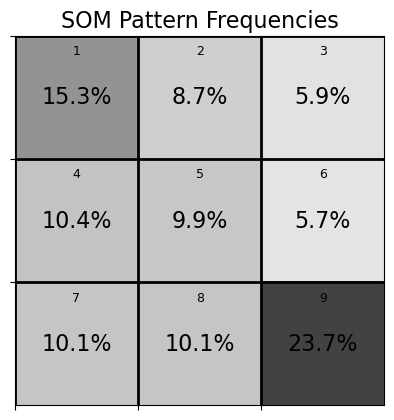

In [13]:
## Create grid plot showing the frequency distribution of cases mapped to each SOM pattern

# Convert frequency variable into forms that can be used for the plot
data = freq.astype(float)
data_label = freq.astype(str)

# Create grid indicating the number of each SOM pattern
cc = np.array(list(range(0,map_size**2)))+1   
cc_str = np.empty(shape=(len(cc)), dtype='object')     
for i in list(range(0,len(cc))):
    cc_str[i] = str(cc[i])
cc_grid = np.empty(shape=(map_size,map_size), dtype='object')  
for i in list(range(0,map_size)):
    cc_grid[i,:] = cc_str[map_size*i:map_size*(i+1)]

# Create discrete greyscale colormap
cmap = get_cmap('Greys')
bounds = np.arange(0, 30, 30/256).tolist() 
norm = colors.BoundaryNorm(bounds, cmap.N)

# Set numbers for axes and labels
min_num = -0.5
max_num = min_num+map_size
col_row_nums = np.empty(shape=(map_size), dtype='object')   
for i in list(range(0,map_size)):
    col_row_nums[i] = 0 + i

## Make figure
fig, ax = plt.subplots()
ax.imshow(data, cmap=cmap, norm=norm)
# Draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(min_num, max_num, 1));
ax.set_yticks(np.arange(min_num, max_num, 1));
ax.get_xaxis().set_ticklabels([])
ax.get_yaxis().set_ticklabels([])
# Write labels
for i in list(range(0,map_size)):
    for j in list(range(0,map_size)):
        ax.annotate(data_label[j,i]+"%", xy=(col_row_nums[i], col_row_nums[j]), fontsize=16, horizontalalignment='center', verticalalignment='center')
        ax.annotate(cc_grid[j,i], xy=(col_row_nums[i], col_row_nums[j]-0.375), fontsize=9, horizontalalignment='center', verticalalignment='center')          
ax.set_title('SOM Pattern Frequencies',fontsize=16)
# Save figure
plt.savefig('Frequency_Grid_'+load_name+'.jpg')


## Step 9: Prepare composite variable (here, total precipitation)

Now that you have run the SOM algorithm to reveal the range of SLP patterns patterns present in the training data, lets look at how total precipitation varies depending on SLP pattern. This will be determined by reading in the total precipitation data from ERA5 (at the same times and locations as the SLP data used to train the SOM) and then finding the average total precipitation amount at each grid cell for each SOM pattern, based on the BMUs (list of cases which are mapped to each SOM pattern).

In [14]:
## Read in the composite variable - total precipitation ##
precip = ds.tp # Total precipitation, in m (over the last forecast hour)

## Save variable names which contain only the data for each variable ##
precip_data = precip.data*1000 # Convert to mm

## Print the shape of the variable to check for consistency ##
# The shape of 'precip_data' should be shapes of (Time, Latitude, Longitude)
print('Total Precip: ' + str(np.shape(precip_data)))
## Check that the dimensions of the precip variable are correct
if (np.shape(precip_data)[0] == len(times_data)) == True & (np.shape(precip_data)[1] == len(lats_data)) == True & (np.shape(precip_data)[2] == len(lons_data)) == True:
    print('Success!')
else:
    print('Something is wrong...')
    

Total Precip: (1096, 81, 81)
Success!


In [15]:
## Flatten the 'precip_data' variable
precip_flat = np.empty(shape=(len_time, idx_flat), dtype='float') ##, dtype='object')
for i in list(range(len_time)):

    # Select the precip data for one time
    precip_now_temp = precip_data[i,:,:]
    
    # Flatten the data
    precip_now = precip_now_temp.reshape(a*b)  
    
    # Save precip data to variable which stores the flattened data for all times
    precip_flat[i,:] = precip_now

## Calculate the average of total precipitation for all cases which map to a given SOM pattern
precip_comp = np.empty(shape=(map_size**2, idx_flat), dtype='object')    
for i in list(range(0,map_size**2)):  
    find = np.where(bmus==i)
    find = find[0]
    for j in list(range(0,idx_flat)): 
        precip_comp[i,j] = np.nanmean(precip_flat[find,j])
        
## Print the shape of the flattened precip variable, to check that it is correct.
print('Shape of flattened total precip variable: ' + str(np.shape(precip_flat)))
if (np.shape(precip_flat)[0] == len(times_data)) == True & (np.shape(precip_flat)[1] == len(lats_data)*len(lons_data)) == True:
    print('Success!')
else:
    print('Something is wrong...')
    

Shape of flattened total precip variable: (1096, 6561)
Success!


## Step 10: Visualize composite variable

Lastly, you will now create a figure which has the same layout as the SOM pattern figure created in Step 5. This new figure shows a map of average total precipitation corresponding to each SOM pattern.

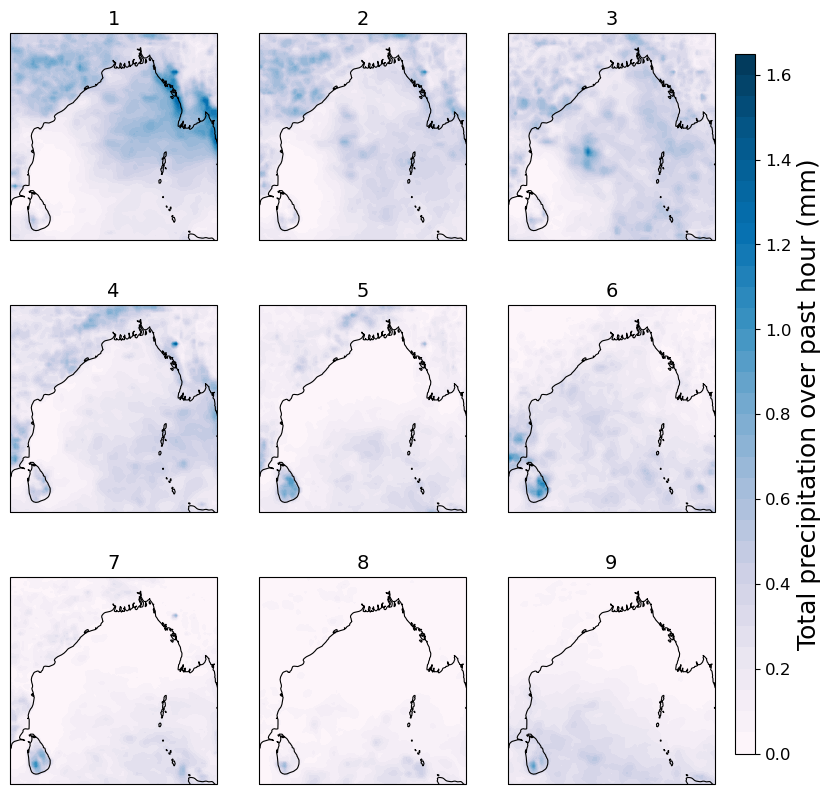

In [16]:
##  Visualize total precipitation in the context of the SOM Patterns

# Define some variables
cc = np.array(list(range(0,map_size**2)))+1    
precip_levels = np.arange(0,1.7,0.05) 
datacrs = ccrs.PlateCarree()

# Make figure 
fig, axs = plt.subplots(nrows=map_size, ncols=map_size, figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})    
axs = axs.ravel()
for i in list(range(0,map_size**2)):       
    comp_img = precip_comp[i,:].reshape(a,b)
    # Set up the map 
    axs[i].set_extent([78, 98, 5, 25], datacrs)
    axs[i].add_feature(cfeature.LAND, facecolor="#bdbdbd") 
    axs[i].coastlines('50m', linewidth=0.8) 
    axs[i].set_title(cc[i],fontsize=14)
    # Define x, y, and z variables for plotting
    x,y = np.meshgrid(lons_data,lats_data)   
    z = comp_img.astype(float)
    ci = axs[i].contourf(x,y,z, levels=precip_levels, cmap=get_cmap('PuBu'), alpha=1, transform=ccrs.PlateCarree())
fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cb = fig.colorbar(ci, cax=cbar_ax)
cb.ax.tick_params(labelsize=12)
cb.set_label('Total precipitation over past hour (mm)',fontsize=18)
# Save figure
plt.savefig('Composite_Patterns_'+load_name+'.jpg')
